# Few vizualisation tools to analyze Neural Networks

First, a bunch of imports and convenience functions

In [7]:
# generic
%matplotlib inline
from __future__ import print_function

# common
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from chainer import cuda, Function, FunctionSet, gradient_check, Variable, optimizers, Chain
import chainer.functions as F
import chainer.links as L

# local
import histdata
from utils import parse_json
from nb_utils import compare
from trading import tm
import tseries
from tseries.converter import Converter
from tseries.indicators import get_functions

# for testing purpose
from IPython import display
import platform
#import plotly
#from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
#import tqdm
import time


In [4]:
# need to be instaled first:
! pip install tqdm
! pip install plotly

Cleaning up...
Downloading/unpacking plotly
  Running setup.py (path:/tmp/pip_build_root/plotly/setup.py) egg_info for package plotly
    
  Running setup.py install for plotly
    
  Could not find .egg-info directory in install record for plotly
Cleaning up...


**For interactive vizualisation of the charts, require plotly:**

In [5]:
import tqdm

from plotly.offline import plot
from plotly.tools import FigureFactory as FF
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

# used for plotly offline
# this injects the plotly.js source files into the notebook
# takes ~3s
init_notebook_mode()

In [8]:
def load_json(path):
    with open(path) as fp:
        return json.loads(fp.read())

def list_packages_versions():
    !date
    print("\ncompiler    : %s"%platform.python_compiler())
    l = platform.linux_distribution()
    print("system      : %s, %s, %s, %s"%(platform.system(),platform.release(),l[0],l[1]))
    print("processor   : %s, %s\n"%(platform.processor(),platform.architecture()[0]))
    
    a = %who_ls module
    for i in a:
        try:
            print("%s %s"%(("%s (%s) "%(globals()[i].__name__,i)).ljust(20,'_'),globals()[i].__version__))
        except:
            pass
list_packages_versions()

Fri Mar  4 08:21:07 UTC 2016

compiler    : GCC 4.8.2
system      : Linux, 3.19.0-50-generic, Ubuntu, 14.04
processor   : x86_64, 64bit

json (json) ________ 2.0.9
numpy (np) _________ 1.10.4
pandas (pd) ________ 0.16.2
platform (platform)  1.0.7
seaborn (sns) ______ 0.7.0
tqdm (tqdm) ________ 3.8.0


# Get the reference

In [10]:
parse_datetime = tm.T.parser("%Y%m%d%H%M")
reference_score = compare.load_reference(parse_json(load_json("/project/exp/reference/downtrend_2015test_1a.json")),
                                         "EURUSD", "5Min", parse_datetime("201501010000"),
                                         parse_datetime("201505302359"))

CPU times: user 2.12 s, sys: 40 ms, total: 2.16 s
Wall time: 2.16 s


---
# Get the historical data

In [11]:
h5 = histdata.get_pandadb()
symbol="EURJPY"
timeframe="5Min"
df = h5[histdata.get_table_name(symbol, timeframe)]

### Work on a small subset

In [12]:
# select what to work on
# min : 2015-01-01 18:00:00
# max : 2015-05-29 21:55:00
beginning, end = "2015-01-02 08:00:00" , "2015-05-29 21:55:00"
#beginning, end = "2015-01-02 08:00:00" , "2015-02-15 21:55:00"
ref = reference_score[beginning : end]
df = df[beginning : end]

Check that data and annotations match...

In [16]:
assert(len(df) == len(ref))

AssertionError: 

Nop! There is **something wrong**. Where?

In [19]:
# find where are the irregularity !!
td = np.timedelta64(300000000000,'ns')
for idx,i in enumerate(df.index.values[:-1]):
    if (df.index.values[idx+1] - df.index.values[idx]) != td:
        #duration of a weekend
        if (df.index.values[idx+1] - df.index.values[idx]) < np.timedelta64(173100000000000,'ns'):
            print(idx)

13703


In [20]:
df.iloc[13702:13706]

,high,close,open,low
2015-03-10 21:50:00+00:00,129.698,129.586,129.554,129.549
2015-03-10 21:55:00+00:00,129.636,129.589,129.586,129.580
2015-03-10 22:05:00+00:00,129.349,129.342,129.342,129.336
2015-03-10 22:10:00+00:00,129.399,129.386,129.363,129.339


**Just after 2015-03-10 21:55:00+00:00 , a frame is skipped  
New breakthrough for the laws of physics? A time tunnel has been discovered?**  
Let's correct it

In [21]:
df = pd.concat([
        df.iloc[:13704],
        pd.DataFrame({"open":[129.636], "high": [129.589], "low": [129.586], "close": [129.58]},
                     index=[pd.to_datetime("2015-03-10 22:00:00+0000",utc=True)]),
        df.iloc[13704:]    
    ])

We're working on:

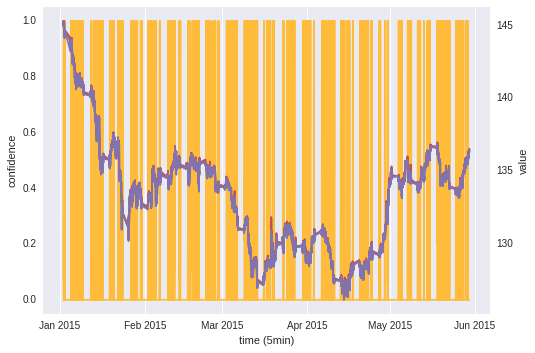

In [34]:
fig, ax1 = plt.subplots()

ax1.plot(ref[beginning : end], color='#FFBB3A')
ax1.set_xlabel('time (5min)')
ax1.set_ylabel('confidence')

ax2 = ax1.twinx()
ax2.plot(df[beginning : end]["open"])
ax2.plot(df[beginning : end]["close"])
ax2.plot(df[beginning : end]["high"])
ax2.plot(df[beginning : end]["low"])
ax2.set_ylabel('value')

ax1.margins(0.05)
ax2.margins(0.05)
ax1.yaxis.grid(False)
ax2.yaxis.grid(False)
plt.show()

### Isolate labeled data

In [35]:
# adding meta stat here?
def isolate_labeled_sequences(sequence,labels):
    t_1=True
    beg = None
    end = None
    l = []
    for i in labels.iterrows():
        if (i[1]!=0)[0] and t_1:
            t_1=False
            beg = i[0]
        if (i[1]==1)[0] and not(t_1):
            # add meta stats here
            t_1=True
            end = i[0]
            l.append(pd.concat([sequence[beg:end],labels[beg:end]],axis=1))
        p=i[0]
    return l

In [36]:
%%time
seq = isolate_labeled_sequences(df,ref)
print(len(seq))

381
CPU times: user 10.2 s, sys: 8 ms, total: 10.2 s
Wall time: 10.2 s


Some basic stats about the annotations

In [37]:
tmp = np.array([len(i) for i in seq])
print(tmp.mean(), tmp.std(), np.median(tmp), tmp.max(), tmp.min())

28.1417322835 14.8347278642 27.0 75 4


### Isolate some unlabeled data as well, useful for evaluation

In [38]:
def isolate_unlabeled_sequences(sequence,labels,min_len=12,max_len=44,nb_extract=10):
    t_1,t_2 = True,True
    beg,end,seq_len = None,None,None
    l = []
    it,extracted = 0,0
    
    for i in labels.iterrows():
        #print(i)
        if (i[1]==0)[0] and t_1 and t_2:
            it = 0
            seq_len = np.random.randint(min_len,max_len)
            t_1=False
            beg = i[0]   
        if (i[1]!=0)[0] and t_2:
            t_2 = False
        if (i[1]==0)[0] and not(t_2):
            t_2 = True
            t_1 = True
        if (i[1]==0)[0] and not(t_1) and t_2 and it>=seq_len:
            # add meta stats here
            t_1=True
            end = i[0]
            l.append(pd.concat([sequence[beg:end],labels[beg:end]],axis=1))
            extracted +=1
        p=i[0]
        it += 1
        if extracted >= nb_extract:
            return l
    print("Ending short, could only retrieve %d"%len(l))
    return l

In [39]:
%%time
neg_seq = isolate_unlabeled_sequences(df,ref,min_len=12,max_len=44,nb_extract=len(seq))
print(len(neg_seq))

381
CPU times: user 12.1 s, sys: 12 ms, total: 12.1 s
Wall time: 12.1 s


#### How does one of the labeled sequence look like?
No added indicators

In [40]:
#docker exec -it 018fb4e0162c pip install plotly --upgrade

# slow on >100 entries!
to_plot = seq[12]

# Add data
open_data = to_plot["open"]
high_data = to_plot["high"]
low_data = to_plot["low"]
close_data = to_plot["close"]
dates = to_plot.index

# Create ohlc
fig = FF.create_candlestick(open_data, high_data,
    low_data, close_data, dates=dates)

iplot(fig, validate=False)

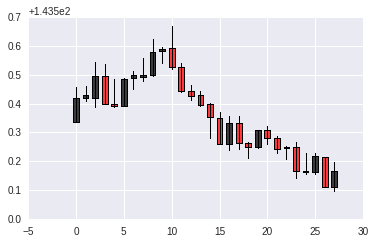

In [42]:
# or using matplotlib
from matplotlib.finance import candlestick2_ohlc

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)

candlestick2_ohlc(ax, open_data, high_data, low_data, close_data, width=0.6, colorup='k', colordown='r', alpha=0.75)
ax.autoscale_view()

plt.show()

#### Any visible pattern in the data?

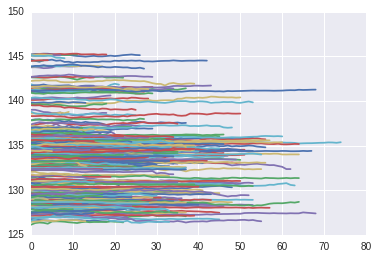

In [43]:
for idx,i in enumerate(seq):
    plt.plot(i["open"].values)
plt.show()

Not really
#### And after normalization?

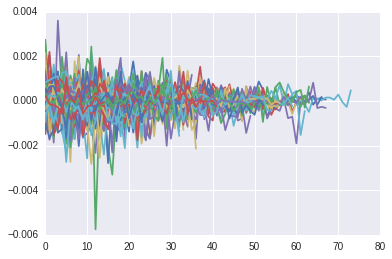

In [44]:
def norma(seq):
    return np.array(map(lambda (x,y): (y-x)/float(y) if x<=y else -(x-y)/float(x), zip(seq[:-1],seq[1:])))
for i in seq:
    plt.plot(norma(i["open"].values))
plt.show()

Not better, look like noise, we only notice a slightly reduced variance toward the end

In [48]:
import plotly.graph_objs as go
# go.Scattergl faster but buggy
# too heavy to plot all
to_plot = []
for idx,i in enumerate(seq[:10]):
    to_plot.append(go.Scatter( y=norma(i["open"].values),
                              mode = 'lines',
                              name = '%d (%d)'%(idx,len(i["open"].values))
                          ))
#plot_url = py.plot(data, filename='date-axes')
iplot(to_plot)

# Fast DTW (on progress)

In [51]:
! pip install fastdtw
import fastdtw
import itertools

Cleaning up...


Using a simple library  
**Despite its name, it is far from fast...**  
[Current state of the art](http://www.cs.ucr.edu/~eamonn/SIGKDD_trillion.pdf) implementation in progress

In [50]:
%%timeit
fastdtw.fastdtw(norma(seq[0]["open"].values) , norma(seq[1]["open"].values))

1000 loops, best of 3: 1.07 ms per loop


In [52]:
%%time
# ~2min

sim = []
for it in itertools.combinations(range(len(seq)),2):
    a,b = norma(seq[it[0]]["open"].values) , norma(seq[it[1]]["open"].values)
    #small series are unsignificant for dtw
    if len(a)>15 and len(b)>15: 
        fdtw = fastdtw.fastdtw(a,b)
        sim.append([ fdtw[0],
                    it[0],
                    it[1],
                    fdtw[1]
                   ])
sim.sort(key=lambda x:x[0])

CPU times: user 1min 39s, sys: 272 ms, total: 1min 39s
Wall time: 1min 39s


The two most similar labeled sequences here: 347 and 356

In [62]:
sim[0][:3]

[0.001671590455868145, 347, 356]

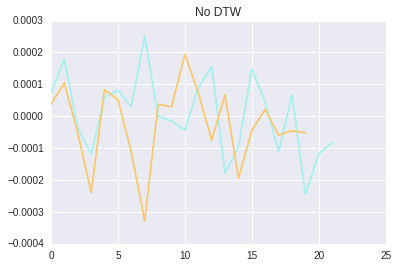

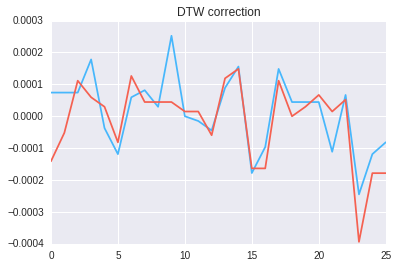

In [65]:
v1 = []
v2 = []
for i,j in sim[0][3]:
    v1.append(norma(seq[347]["open"].values)[i])
    v2.append(norma(seq[356]["open"].values)[j])

plt.plot(norma(seq[347]["open"].values),color="#A5F0EE")
plt.plot(norma(seq[304]["open"].values),color="#FAC86B")
plt.title("No DTW")
plt.show()
plt.plot(v1,color="#47B7FC")
plt.plot(v2,color="#F56151")
plt.title("DTW correction")
plt.show()

The 5 most similar sequences

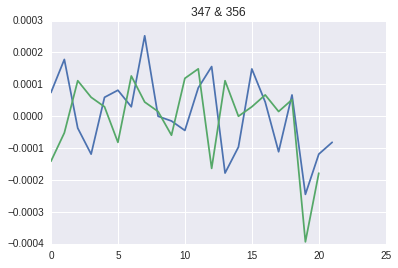

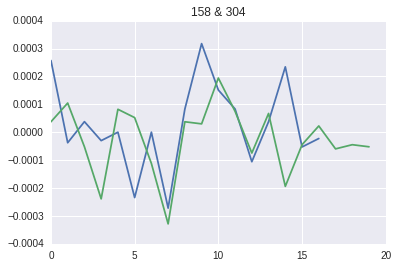

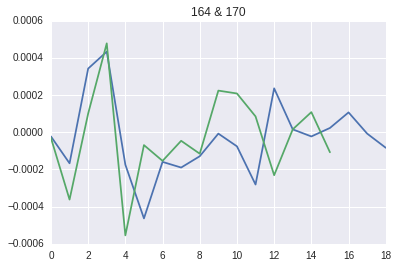

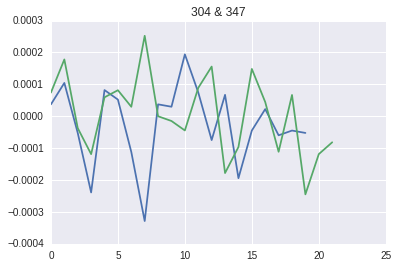

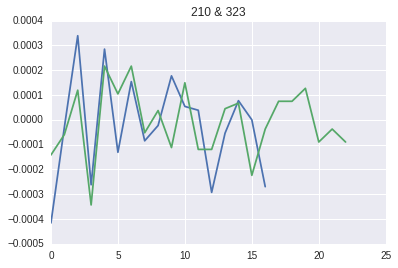

In [72]:
for i in sim[:5]:
    plt.plot(norma(seq[i[1]]["open"].values))
    plt.plot(norma(seq[i[2]]["open"].values))
    plt.title("%d & %d"%(i[1],i[2]))
    plt.show()

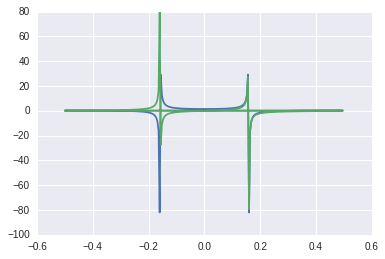

In [74]:
# docker exec -it 018fb4e0162c pip install fastdtw

x = np.array([5,1,1,4,1,1,3,5,1,4,1,1,2,3,4,1,4,1,1,1,1,1,1])
y = np.array([1,2,3,4,1,4,1])
fastdtw.fastdtw(x,y)

%matplotlib inline
t = np.arange(256)
sp = np.fft.fft(np.sin(t))
freq = np.fft.fftfreq(t.shape[-1])
plt.plot(freq, sp.real, freq, sp.imag)

plt.show()

In [75]:
## in progress

def DFT_slow(x):
    """Compute the discrete Fourier Transform of the 1D array x"""
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    n = np.arange(N)
    k = n.reshape((N, 1))
    M = np.exp(-2j * np.pi * k * n / N)
    return np.dot(M, x)

x = np.random.random(8)
x = np.pad(x,[0,16-len(x)],mode="constant")
y = np.random.random(16)
rx = DFT_slow(x)
ry = DFT_slow(y)
print(x)
print(y)
print(rx)
print(ry)
#print(np.fft.ifft(rx))
rx*ry
#np.fft.rfft(x)


# pseudo-code from:
# http://www.cs.unm.edu/~mueen/FastestSimilaritySearch.html

#def findNN(x,y):

x = np.array([1,1,1,1,1,1,2,3,4,1,4,1,1,1,1,1])
#x = np.array([1,2,3,4,1,4,1])*2
y = np.array([1,2,3,4,1,4,1])

#x is the data, y is the query
n = len(x)
#y = (y-np.mean(y))/np.std(y)                #Normalize the query
m = len(y)
x = np.append(x,np.zeros(n)) #x(n+1:2*n) = 0                                 #Append zeros
y = y[::-1]                  #y = y(end:-1:1)                                #Reverse the query
y = np.append(y,np.zeros(m)) #y(m+1:2*n) = 0                                 #Append zeros

#The main trick of getting dot products in O(n log n) time
y = np.pad(y,[0,len(x)-len(y)],mode="constant")
X = np.fft.fft(x)                                     #Change to Frequency domain
Y = np.fft.fft(y)                                     #Change to Frequency domain
## not element wise mult?? Z = X*Y
## cant do the inverse fourier transform if we .dot ...
Z = X*Y                                       #Do the dot product
#print(np.shape(Z))
#print(Z)
z = np.fft.ifft(Z)                                    #Come back to Time domain

#compute y stats -- O(n)
sumy = np.sum(y)
sumy2 = np.sum(y**2) #sum(y.^2)

#compute x stats -- O(n)
cum_sumx = np.cumsum(x)                           #Cumulative sums of x
cum_sumx2 = np.cumsum(x**2)                       #Cumulative sums of x^2
sumx2 = cum_sumx2[m+1:n]-cum_sumx2[1:n-m] #cum_sumx2(m+1:n)-cum_sumx2(1:n-m)      #Sum of x^2 of every subsequences of length m
sumx = cum_sumx[m+1:n]-cum_sumx[1:n-m] #cum_sumx(m+1:n)-cum_sumx(1:n-m)         #Sum of x of every subsequences of length m
meanx = sumx/float(m)                                #Mean of every subsequences of length m
sigmax2 = (sumx2/float(m))-(meanx**2)
sigmax = np.sqrt(sigmax2)                         #Standard deviaiton of every subsequences of length m


#computing the distances -- O(n) time.
#dist = (sumx2 - 2*sumx.*meanx + m*(meanx.^2))./sigmax2 - 2*(z(m+1:n) - sumy.*meanx)./sigmax + sumy2
#a = sumy.dot(meanx)/sigmax + sumy2

dist = (sumx2 - 2*sumx*meanx + m*(meanx**2))/sigmax2 - 2*(z[m+1:n] - sumy*meanx)/sigmax + sumy2
dist = np.sqrt(dist)

dist
    #return dist


[ 0.20306083  0.70658936  0.6142719   0.71095751  0.43754512  0.35212871
  0.69681478  0.79722211  0.          0.          0.          0.          0.
  0.          0.          0.        ]
[ 0.2535267   0.93123841  0.21762402  0.7870809   0.19575819  0.37893918
  0.38759547  0.74325752  0.69670053  0.90863801  0.70147669  0.28642275
  0.78251039  0.63446219  0.86775378  0.03779525]
[ 4.51859031 +0.00000000e+00j  0.19827830 -2.92227073e+00j
  0.07715553 -1.07100371e-01j -0.10477078 -1.47204833e+00j
 -0.67048073 +4.49461556e-01j  0.62762570 -4.92981996e-01j
 -0.54612411 -2.72186123e-01j  0.09111011 -1.93023938e-01j
 -0.61520507 -3.69971590e-16j  0.09111011 +1.93023938e-01j
 -0.54612411 +2.72186123e-01j  0.62762570 +4.92981996e-01j
 -0.67048073 -4.49461556e-01j -0.10477078 +1.47204833e+00j
  0.07715553 +1.07100371e-01j  0.19827830 +2.92227073e+00j]
[ 8.81077999 +0.00000000e+00j -0.78729024 +7.63318047e-01j
  0.34957076 -4.54951575e-01j -1.40050173 -4.83926559e-01j
 -0.24595415 -9.98721360e

array([ 7.61892401 +2.99895382e-15j,  6.88331260 +2.04749280e-15j,
        7.78396878 +3.46038073e-15j,  6.09191728 +3.16932423e-15j,
        7.78396878 +1.86239935e-15j,  7.24363016 +1.82700592e-15j,
        7.58484160 +1.10164247e-15j,  7.52548956 +5.48571972e-16j])

---
# Normalization

After lots of different experiments, a simple normalization seem to work better  
Simplest, fit into tanh range:

In [76]:
def norma(seq):
    return np.array(map(lambda (x,y): (y-x)/float(y) if x<=y else -(x-y)/float(x), zip(seq[:-1],seq[1:])))

def norm_and_center(x,scale=1):
    c2 = norma(x)
    c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
    return np.array([[[i]] for i in c]).astype(np.float32)
#cc = norm_and_center(seq[11]["open"].values)

---
# Experiments with a vanilla NN

In [77]:
hidden=15
class SimpleRNN(Chain):
    def __init__(self):
        super(SimpleRNN, self).__init__(
            l1 = L.Linear(1,hidden),
            l2 = L.LSTM(hidden,hidden),
            l3 = L.Linear(hidden,1),
        )
        
    def reset_state(self):
        self.l2.reset_state()
    
    def __call__(self,x):
        h1 = self.l1(x)
        h2 = self.l2(h1)
        h3 = self.l3(h2)
        return h3

class Cla(Chain):
    def __init__(self, predictor):
        super(Cla, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = F.mean_squared_error(y, t)
        #self.loss = np.abs(t - y) 
        #self.loss = np.power(np.abs(t - y) , 1.2)
        #self.loss = np.power(np.abs(t - y) , 1.1)
        #self.loss = F.gaussian_kl_divergence(y, t)
        #self.accuracy = F.accuracy(y, t)
        return self.loss

def compute_loss(x_list):
    loss = 0
    for cur_word, next_word in zip(x_list, x_list[1:]):
        loss += model(Variable(cur_word), Variable(next_word))
        #loss += model(Variable(cuda.to_gpu(cur_word)),
        #              Variable(cuda.to_gpu(next_word)))
        #loss += model(cuda.to_gpu(cur_word), cuda.to_gpu(next_word))
    return loss

In [84]:
def train(rnn,model,optimizer,x_train,nb_epoch=100,print_every=-1,use_gpu=False):

    print_every = print_every if print_every!=-1 else nb_epoch/10
    
    predicted = []
    loss_log = []
    #
    #model.to_gpu()

    #cc = norm_and_center(seq[3]["open"].values)
    
    def compute_loss(x_list):
        loss = 0
        for cur_word, next_word in zip(x_list, x_list[1:]):
            if use_gpu:
                loss += model(Variable(cuda.to_gpu(cur_word)),
                              Variable(cuda.to_gpu(next_word)))
            else:
                loss += model(Variable(cur_word), Variable(next_word))
        return loss


    fig,ax = plt.subplots(1,1)
    #fig2,ax2 = plt.subplots(1,1)
    fig2,ax2 = plt.subplots(1,1)

    for i in tqdm.tqdm(range(nb_epoch),smoothing=0.1):
    #for i in range(nb_epoch):
        
        example = x_train[np.random.randint(len(x_train))]
        
        rnn.reset_state()
        model.zerograds()
        loss = compute_loss(example)
        loss.backward()
        optimizer.update()
        loss_log.append(loss.data)
        #loss_log.append(loss.data[0][0])

        # plot graphs
        if i%print_every == 0:
            #print("It: %s, Loss: %.16f"%(str(i).rjust(10) , loss.data) )
            rnn.reset_state()
            predicted = []
            for idx,j in enumerate(example[:-1]):     
                #print("Pred %.03f, True %.03f"%(model.predictor(Variable(i)).data , cc[idx+1][0][0]))
                #predicted.append(model.predictor(Variable(cuda.to_gpu(j))).data)
                predicted.append(model.predictor(Variable(j)).data)
            ax.clear()
            ax.plot([p[0][0] for p in example],label="True")
            ax.plot([p[0][0] for p in predicted],label="Pred at epoch %d"%(i))
            ax.legend()
            fig.canvas.draw()

            #ax2.clear()
            #ax2.plot(loss_log,label="Loss at %d"%i,color="red")
            #ax2.legend()
            #fig2.canvas.draw()
            #loss_log = []

    #print("over")
            #fig2,ax2 = plt.subplots(1,1)
            ax2.clear()
            ax2.plot(loss_log,label="Training loss\n(loss: %.3e)\n(logarithmic scale)"%(loss.data),color="red")
            ax2.set_yscale('log')
            ax2.legend()
            fig2.canvas.draw()
        

In [79]:
rnn = SimpleRNN()
model = Cla(rnn)
#model.to_gpu()
#optimizer = optimizers.MomentumSGD(lr=0.01, momentum=0.9)
#optimizer = optimizers.NesterovAG(lr=0.01, momentum=0.9)
optimizer = optimizers.AdaDelta()
#optimizer = optimizers.SGD(lr=0.02)
optimizer.setup(model)

### Let's first try to fit one pattern only:

<IPython.core.display.Javascript object>


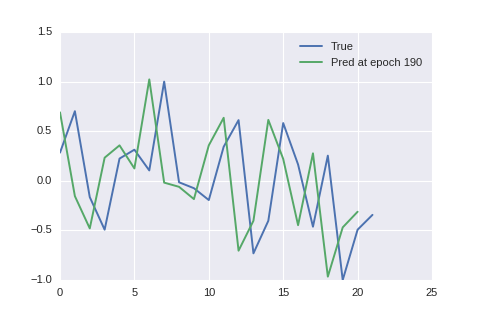

<IPython.core.display.Javascript object>


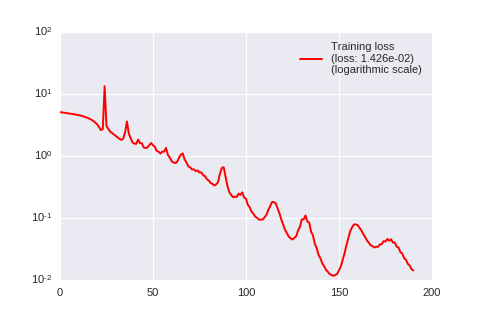

<IPython.core.display.Javascript object>


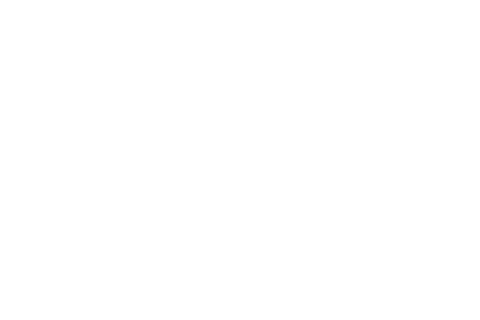

<IPython.core.display.Javascript object>


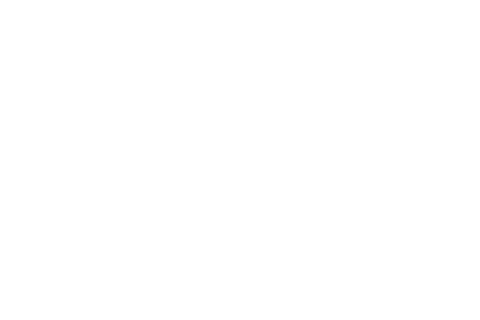

In [100]:
%matplotlib notebook
#347, 356, 323
x_train = [norm_and_center(seq[347]["open"].values,scale=100)]

rnn = SimpleRNN()
model = Cla(rnn)
optimizer = optimizers.AdaDelta()
optimizer.setup(model)

train(rnn,model,optimizer,x_train,nb_epoch=200,print_every=10,use_gpu=False)

It learn very quickly, the task is quite easy.  
How does it predict a known data? An unknown one?

In [101]:
def show_one_prediction(example):
    fig,ax = plt.subplots(1,1)
    rnn.reset_state()
    predicted = []
    for idx,j in enumerate(example[:-1]):     
        predicted.append(model.predictor(Variable(j)).data)
    #ax.clear()
    ax.plot([p[0][0] for p in example[1:]],label="True")
    ax.plot([p[0][0] for p in predicted],label="Prediciton (shifted)")
    ax.legend()
    fig.canvas.draw()

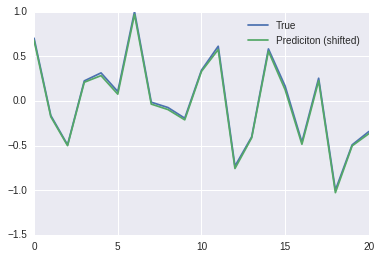

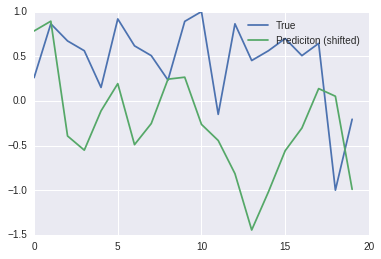

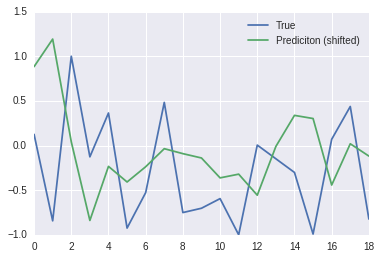

In [103]:
%matplotlib inline
show_one_prediction(norm_and_center(seq[347]["open"].values,scale=10))
show_one_prediction(norm_and_center(seq[356]["open"].values,scale=10))  # related data
show_one_prediction(norm_and_center(seq[45]["open"].values,scale=10))   # unrelated

Not good in either case.  
With different training data?

<IPython.core.display.Javascript object>


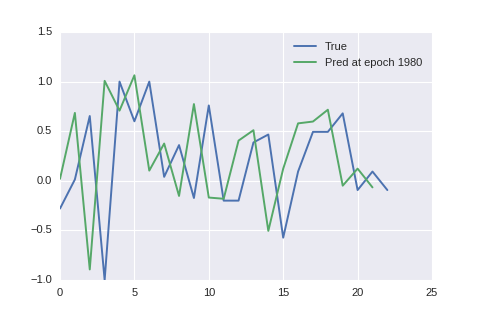

<IPython.core.display.Javascript object>


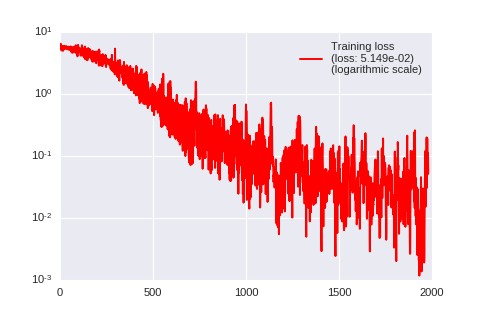

<IPython.core.display.Javascript object>


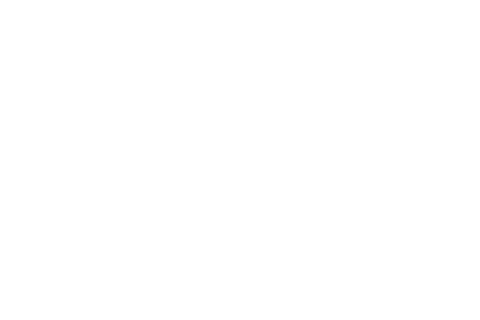

<IPython.core.display.Javascript object>


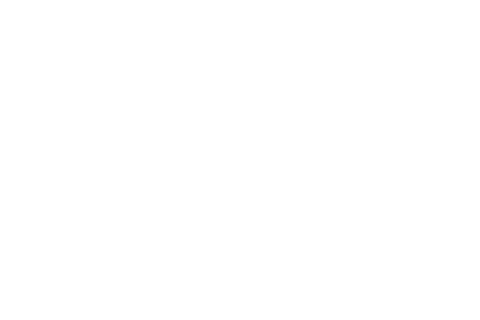

In [109]:
%matplotlib notebook
#347, 356, 323
x_train = [norm_and_center(seq[347]["open"].values,scale=100),
          norm_and_center(seq[356]["open"].values,scale=100),
          norm_and_center(seq[323]["open"].values,scale=100)]

rnn = SimpleRNN()
model = Cla(rnn)
optimizer = optimizers.AdaDelta()
optimizer.setup(model)

train(rnn,model,optimizer,x_train,nb_epoch=2000,print_every=20,use_gpu=False)

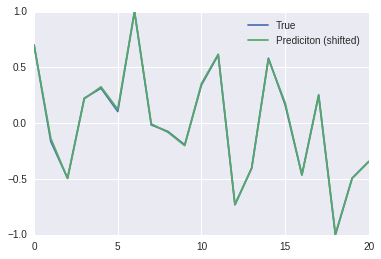

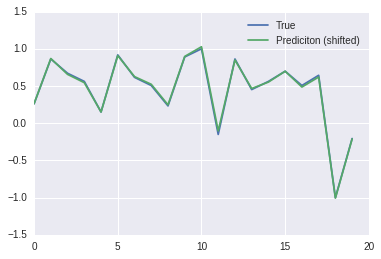

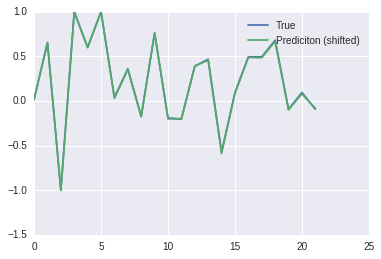

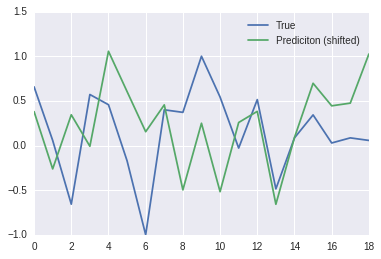

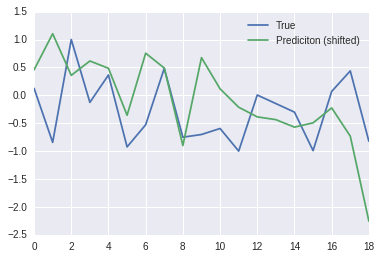

In [111]:
%matplotlib inline
show_one_prediction(norm_and_center(seq[347]["open"].values,scale=10))
show_one_prediction(norm_and_center(seq[356]["open"].values,scale=10))
show_one_prediction(norm_and_center(seq[323]["open"].values,scale=10))
show_one_prediction(norm_and_center(seq[304]["open"].values,scale=10))  # somehow related
show_one_prediction(norm_and_center(seq[45]["open"].values,scale=10))   # unrelated

Not better.  

---

The network is really good to memorize sequence quickly, and it is easier with more input dimensions.  
Next step, add the features and generalize from there

--- 




---



---


---

In [345]:
for idx,j in enumerate(cc[:-1]):     
    print(j[0][0])
    print(">>",model.predictor(Variable(j)).data[0][0])

0.283694
>> -0.874144
0.701675
>> -0.885138
-0.164253
>> -1.32254
-0.492726
>> -0.261942
0.223945
>> -0.682081
0.313505
>> -0.782773
0.104482
>> 0.273587
1.0
>> -0.566777
-0.0149551
>> -0.558535
-0.0746583
>> -0.571217
-0.194067
>> -0.0446074
0.343254
>> 0.177254
0.611813
>> -1.1428
-0.731261
>> -0.615131
-0.403023
>> 0.432242
0.582042
>> -0.109145
0.164136
>> -0.801306
-0.462683
>> 0.16594
0.253694
>> -1.25785
-1.0
>> -0.532839
-0.49267
>> -0.437808


In [ ]:
def train(rnn,model,optimizer,x_train,y_train,nb_epoch=100,print_every=-1,use_gpu=False):

    print_every = print_every if print_every==-1 else nb_epoch/10
    
    predicted = []
    loss_log = []
    #
    #model.to_gpu()

    cc = norm_and_center(seq[3]["open"].values)

    fig,ax = plt.subplots(1,1)
    #fig2,ax2 = plt.subplots(1,1)
    
    def compute_loss(x_list):
        loss = 0
        for cur_word, next_word in zip(x_list, x_list[1:]):
            if use_gpu:
                loss += model(Variable(cuda.to_gpu(cur_word)),
                              Variable(cuda.to_gpu(next_word)))
            else:
                loss += model(Variable(cur_word), Variable(next_word))
        return loss

    for i in range(nb_epoch):
        rnn.reset_state()
        model.zerograds()
        loss = compute_loss(cc)
        loss.backward()
        optimizer.update()
        loss_log.append(loss.data)

        # plot graphs
        if i%print_every == 0:
            print("It: %s, Loss: %.09f"%(str(i).rjust(10) , loss.data) )

            predicted = []
            for idx,j in enumerate(cc[:-1]):     
                #print("Pred %.03f, True %.03f"%(model.predictor(Variable(i)).data , cc[idx+1][0][0]) )
                #predicted.append(model.predictor(Variable(cuda.to_gpu(j))).data)
                predicted.append(model.predictor(Variable(j)).data)
            ax.clear()
            ax.plot([p[0][0] for p in cc],label="True")
            ax.plot([p[0][0] for p in predicted],label="Pred at %d"%i)
            ax.legend()
            fig.canvas.draw()

            #ax2.clear()
            #ax2.plot(loss_log,label="Loss at %d"%i,color="red")
            #ax2.legend()
            #fig2.canvas.draw()

            #loss_log = []

    print("over")
    fig2,ax2 = plt.subplots(1,1)
    ax2.plot(loss_log,label="Training loss\n(logarithmic scale)",color="red")
    ax2.set_yscale('log')
    ax2.legend()
    plt.show()

    return loss_log

In [ ]:
fig2,ax2 = plt.subplots(1,1)
ax2.clear()
ax2.plot(loss_log,label="Loss at %d"%i,color="red")
ax2.legend()
fig2.canvas.draw()

<IPython.core.display.Javascript object>


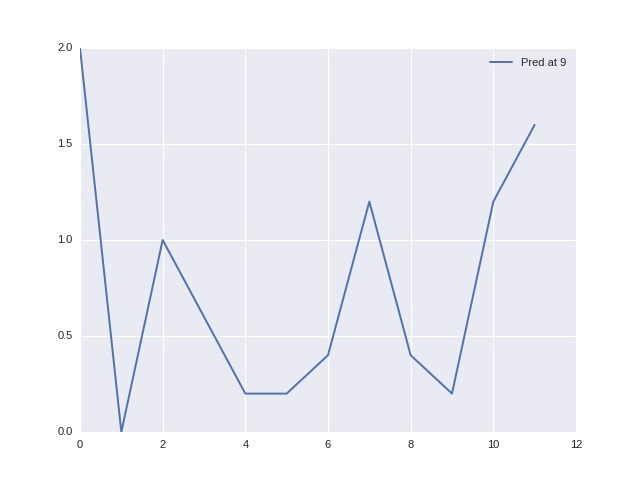

<IPython.core.display.Javascript object>


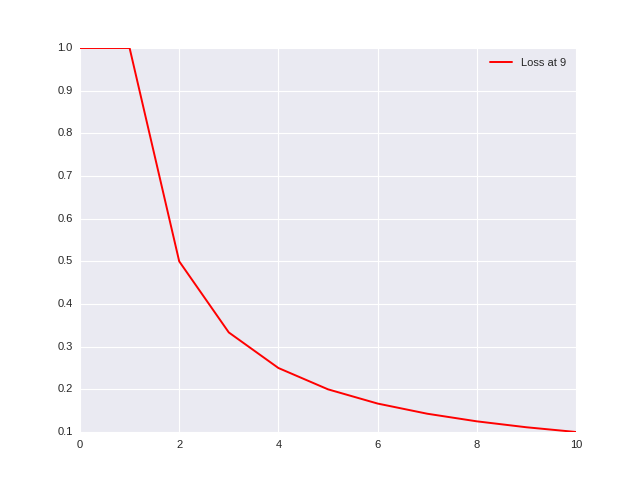

In [19]:
#%matplotlib notebook

import time

fig,ax = plt.subplots(1,1)
fig2,ax2 = plt.subplots(1,1)
predicted = [2,0]
p = [1]
for i in range(10):
    predicted.append(np.random.randint(1,10)/5.)
    ax.clear()
    ax.plot(predicted,label="Pred at %d"%i)
    ax.legend()
    fig.canvas.draw()
    
    p.append(1./(i+1))
    ax2.clear()
    ax2.plot(p,label="Loss at %d"%i,color="red")
    ax2.legend()
    ax2.set_yscale('log')
    fig2.canvas.draw()
    
    time.sleep(0.2)


In [279]:
hidden=15
class SimpleRNN(Chain):
    def __init__(self):
        super(SimpleRNN, self).__init__(
            l1 = L.Linear(1,hidden),
            l2 = L.LSTM(hidden,hidden),
            l3 = L.Linear(hidden,1),
        )
        
    def reset_state(self):
        self.l2.reset_state()
    
    def __call__(self,x):
        h1 = self.l1(x)
        h2 = self.l2(h1)
        h3 = self.l3(h2)
        return h3

class Cla(Chain):
    def __init__(self, predictor):
        super(Cla, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = F.mean_squared_error(y, t)
        #self.loss = F.softmax(y,t)
        #self.accuracy = F.accuracy(y, t)
        return self.loss

def compute_loss(x_list):
    loss = 0
    for cur_word, next_word in zip(x_list, x_list[1:]):
        loss += model(Variable(cur_word), Variable(next_word))
        #loss += model(Variable(cuda.to_gpu(cur_word)),
        #              Variable(cuda.to_gpu(next_word)))
    return loss

In [289]:
rnn = SimpleRNN()
model = Cla(rnn)
#model.to_gpu()
optimizer = optimizers.MomentumSGD(lr=0.0001, momentum=0.9)
optimizer.setup(model)

In [292]:
def train(rnn,model,optimizer,x_train,y_train,nb_epoch=10):
    print_every = nb_epoch/10
    predicted = []
    #model.to_gpu()

    for i in range(nb_epoch):
        for idxj,j in enumerate(x_train):
            rnn.reset_state()
            model.zerograds()
            #loss = compute_loss(cc)

            x_list = j
            loss = 0
            for idx_list,cur_word in enumerate(x_list):
                loss += model(Variable(cur_word), Variable(y_train[idxj][idx_list]))
            loss.backward()
            optimizer.update()
        
        
        if i%print_every == 0:
            print(loss.data)
        #    print("It: %s, Loss: %.09f"%(str(i).rjust(10) , loss.data) )
train(rnn,model,optimizer,x_train,y_train,nb_epoch=100)

2.76180696487
2.74219655991
2.72951173782
2.71836495399
2.71101307869
2.70852565765
2.71127271652
2.71898365021
2.73087286949
2.74591135979


In [293]:
for idx,i in enumerate(x_train):
    print(model.predictor(Variable(x_train[idx][0])).data)
    print(y_train[idx][0])

[[-1.40001774]]
[[ 1.]]
[[-1.16897988]]
[[ 1.]]
[[-1.32574773]]
[[ 1.]]
[[-1.76312327]]
[[ 1.]]
[[-2.07155132]]
[[ 1.]]
[[-1.9925952]]
[[ 1.]]
[[-1.71506715]]
[[ 1.]]
[[-1.94466805]]
[[-1.]]
[[-1.60818863]]
[[-1.]]
[[-1.45551586]]
[[-1.]]
[[-1.78029084]]
[[-1.]]
[[-1.49156594]]
[[-1.]]
[[-1.44166589]]
[[-1.]]


In [286]:
model.predictor(Variable(x_train[0][0])).data

array([[ 2.46279144]], dtype=float32)

In [262]:
cut_at = np.array([len(i) for i in seq]).min()
x_train = []
for i in seq:
    c2 = i["open"].values
    c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
    cc = np.array([[[i]] for i in c[:cut_at]]).astype(np.float32)
    x_train.append(cc)

In [263]:
y_train = np.array([[[[1]] for j in range(len(i))] for i in x_train]).astype(np.float32)

In [264]:
#cut_at = np.array([len(i) for i in seq]).min()
neg_x_train = []
for i in neg_seq:
    c2 = i["open"].values
    c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
    cc = np.array([[[i]] for i in c[:cut_at]]).astype(np.float32)
    neg_x_train.append(cc)

In [265]:
neg_y_train = np.array([[[[-1]] for j in range(len(i))] for i in neg_x_train]).astype(np.float32)

In [266]:
x_train.extend(neg_x_train)
y_train = np.concatenate((y_train,neg_y_train), axis=0)

In [49]:
c2 = seq[1]["open"].values
c = 2*(c2 - c2.min())/(c2.max() - c2.min()) - 1
cc = np.array([[[i]] for i in c]).astype(np.float32)


nb_epoch = 200
print_every = nb_epoch/10
predicted = []
#model.to_gpu()

for i in range(nb_epoch):
    rnn.reset_state()
    model.zerograds()
    loss = compute_loss(cc)
    loss.backward()
    optimizer.update()
    if i%print_every == 0:
        print("It: %s, Loss: %.09f"%(str(i).rjust(10) , loss.data) )
        
        predicted = []
        for idx,j in enumerate(cc[:-1]):     
            #print("Pred %.03f, True %.03f"%(model.predictor(Variable(i)).data , cc[idx+1][0][0]) )
            predicted.append(model.predictor(Variable(cuda.to_gpu(j))).data)
            #predicted.append(model.predictor(Variable(j)).data)

It:          0, Loss: 0.000069149
It:         20, Loss: 0.000044444
It:         40, Loss: 0.000028744
It:         60, Loss: 0.000018606
It:         80, Loss: 0.000012050
It:        100, Loss: 0.000007803
It:        120, Loss: 0.000005054
It:        140, Loss: 0.000003275
It:        160, Loss: 0.000002122
It:        180, Loss: 0.000001374


In [51]:
results = None
losss = []
#model.to_gpu()
model.zerograds()
for t in xrange(0, 100):
    #document = np.array([[[5]], [[4]], [[3]], [[2]], [[1]], [[2]], [[3]], [[4]], [[5]]]).astype(np.float32)
    document = cc
    optimizer.zero_grads()
    loss, results = forward(document)
    
    if t%10==0:
        print("It: %d, loss: %.02f"%(t,loss.data[0][0]))
        #print([i[0][0] for i in results])
        losss.append(loss.data[0][0])
        
        plt.gca().cla() 
        plt.plot([i[0][0] for i in cc],label="True")
        plt.plot([i[0][0] for i in results],label="Pred at %d"%t)
        plt.legend()

        display.display(plt.gcf()) 
        display.clear_output(wait=True)
    
    loss.backward()
    optimizer.update()

#print(["%.03f"%i[0][0] for i in results])
#print(["%.03f"%i[0][0] for i in cc])
plt.show()
plt.plot(losss,label="Loss")
plt.legend()
plt.show()
print("*-.-*")

AttributeError: 'Cla' object has no attribute 'Wx'

In [114]:
x = cuda.to_gpu(np.array([1,2]),device=0)

In [115]:
x.data

It: 00900, Loss: 0.001507


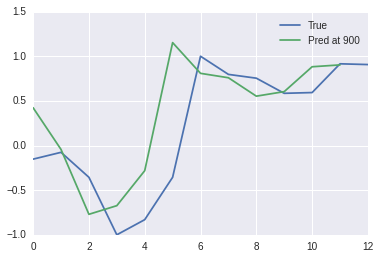

In [53]:
nb_epoch = 1000
predicted = []

for i in range(nb_epoch):
    rnn.reset_state()
    model.zerograds()
    loss = compute_loss(cc)
    loss.backward()
    optimizer.update()
    if i%100 == 0:
        
        predicted = []
        for idx,j in enumerate(cc[:-1]):     
            #print("Pred %.03f, True %.03f"%(model.predictor(Variable(i)).data , cc[idx+1][0][0]) )
            predicted.append(model.predictor(Variable(j)).data)
        plt.gca().cla() 
        plt.plot([p[0][0] for p in cc],label="True")
        plt.plot([p[0][0] for p in predicted],label="Pred at %d"%i)
        plt.legend()

        display.display(plt.gcf()) 
        display.clear_output(wait=True)
        
        print("It: %05d, Loss: %f"%(i , loss.data) )

In [185]:
for idx,i in enumerate(cc[:-1]):
    print("Pred %.03f, True %.03f"%(model.predictor(Variable(i)).data , cc[idx+1][0][0]) )

Pred 0.581, True -0.076
Pred 0.366, True -0.356
Pred -0.328, True -1.000
Pred -0.403, True -0.831
Pred -0.167, True -0.356
Pred -0.847, True 1.000
Pred 0.850, True 0.797
Pred 0.760, True 0.754
Pred 0.574, True 0.585
Pred 0.664, True 0.593
Pred 0.873, True 0.915
Pred 0.933, True 0.907


In [75]:
model.predictor(Variable(cc[0])).data

array([[ 0.09446953]], dtype=float32)

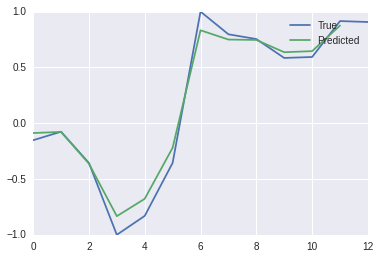

In [29]:
plt.plot([i[0][0] for i in cc],label="True")
plt.plot([i[0][0] for i in results],label="Predicted")
plt.legend()
plt.show()

In [30]:
print(["%.03f"%i[0][0] for i in results])
print(["%.03f"%i[0][0] for i in cc[1:]])

['-0.088', '-0.078', '-0.362', '-0.833', '-0.677', '-0.220', '0.833', '0.750', '0.746', '0.636', '0.646', '0.875']
['-0.076', '-0.356', '-1.000', '-0.831', '-0.356', '1.000', '0.797', '0.754', '0.585', '0.593', '0.915', '0.907']


In [ ]:
class MLP(Chain):
    def __init__(self):
        super(MLP, self).__init__(
            l1=L.Linear(784, 100),
            l2=L.Linear(100, 100),
            l3=L.Linear(100, 10),
        )
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        y = self.l3(h2)
        return y

In [ ]:
class Classifier(Chain):
    def __init__(self, predictor):
        super(Classifier, self).__init__(predictor=predictor)
    def __call__(self, x, t):
        y = self.predictor(x)
        self.loss = F.softmax_cross_entropy(y, t)
        self.accuracy = F.accuracy(y, t)
        return self.loss

In [ ]:
model = L.Classifier(MLP())
optimizer = optimizers.SGD()
optimizer.setup(model)

In [ ]:
batchsize = 100
datasize = 60000  
for epoch in range(20):
    print('epoch %d' % epoch)
    indexes = np.random.permutation(datasize)
    for i in range(0, datasize, batchsize):
        x = Variable(x_train[indexes[i : i + batchsize]])
        t = Variable(y_train[indexes[i : i + batchsize]])
        optimizer.update(model, x, t)

In [ ]:
batchsize = 100
datasize = 60000  
for epoch in range(20):
    print('epoch %d' % epoch)
    indexes = np.random.permutation(datasize)
    for i in range(0, datasize, batchsize):
        x = Variable(x_train[indexes[i : i + batchsize]])
        t = Variable(y_train[indexes[i : i + batchsize]])
        model.zerograds()
        loss = model(x, t)
        loss.backward()
        optimizer.update()

In [ ]:
sum_loss, sum_accuracy = 0, 0
for i in range(0, 10000, batchsize):
    x = Variable(x_test[i : i + batchsize])
    t = Variable(y_test[i : i + batchsize])
    loss = model(x, t)
    sum_loss += loss.data * batchsize
    sum_accuracy += model.accuracy.data * batchsize
mean_loss = sum_loss / 10000
mean_accuracy = sum_accuracy / 10000

---

In [ ]:
class RNN(Chain):
    def __init__(self):
        super(RNN, self).__init__(
            embed=L.EmbedID(1000, 100),  # word embedding
            mid=L.LSTM(100, 50),  # the first LSTM layer
            out=L.Linear(50, 1000),  # the feed-forward output layer
        )

    def reset_state(self):
        self.mid.reset_state()

    def __call__(self, cur_word):
        # Given the current word ID, predict the next word.
        x = self.embed(cur_word)
        h = self.mid(x)
        y = self.out(h)
        return y

rnn = RNN()
model = L.Classifier(rnn)
optimizer = optimizers.SGD()
optimizer.setup(model)

In [ ]:
def compute_loss(x_list):
    loss = 0
    for cur_word, next_word in zip(x_list, x_list[1:]):
        loss += model(cur_word, next_word)
    return loss